In [2]:
from __future__ import division
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from scipy.special import expit
import random
from random import randint
import nltk
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
%matplotlib inline

wordnet_lemmatizer = WordNetLemmatizer()

In [3]:
def plot_cost(iter_list,cost_list):
    plt.plot(iter_list,cost_list,'r.')
    plt.xlabel('Iterations ->')
    plt.ylabel('Cost')
    plt.show()

In [31]:
def plot_together(iter_list,cost_list,test_list):
    plt.plot(iter_list,cost_list,'r--',label='Training(In-sample) Error')
    plt.plot(iter_list,test_list,'b--',label='Test(Out-of-sample) Error')
    plt.legend()
    plt.xlabel('Iterations ->')
    plt.ylabel('Cost')
    plt.show()

In [15]:
def sigmoid(x):
    return expit(x)
def tanh(x):
    return np.tanh(x)


In [16]:
def activation_func(z,func='sigmoid'):
    if(func=='sigmoid'):
        return sigmoid(z)
    else:
        #print("returning tanhz, ",tanh(z))
        return tanh(z)

In [17]:
def derivative_sigmoid(z):
    g_z=sigmoid(z)
    return g_z*(1-g_z)
def derivative_tanh(z):
    g_z=tanh(z)
    return (1-g_z*g_z)

In [18]:
def cross_entropy(Y,Y_pred):
    loss=0.0
    m=len(Y)
    for i in range(m):
        if (np.argmax(Y[i]==0)):
            loss+=(-1.0)*np.log(Y_pred[i][0])
            #loss+=(-1.0)*np.log(np.exp(Y_pred[i][0])/np.sum(np.exp(Y_pred[i])))
        else:
            loss+=(-1.0)*np.log(Y_pred[i][1])
            #loss+=(-1.0)*np.log(np.exp(Y_pred[i][1])/np.sum(np.exp(Y_pred[i])))
    return (loss/m)

In [19]:
def mse(Y,Y_pred):
    m=len(Y)
    J = np.sum((Y_pred - Y) ** 2)/(2 * m)
    return J

In [54]:
def predict(W,b,X,dim):
    y_pred=list()
    L=len(dim)-1
    N=len(X)
    threshold=0.2
    a=dict()
    z=dict()
    
    for i in range(1,L+1):
        a[i]=np.empty(shape=[1,dim[i]])
        z[i]=np.empty(shape=[1,dim[i]])
        
        
    for n in range(N):
    
        a[0]=X[n]
        
        # Forward Pass
        for l in range(1,L+1):
            z[l]=a[l-1].dot(W[l])+b[l]
            a[l]=activation_func(z[l],'tanh')
            

        z[L]-= np.max(z[L]) 
        a[L] = np.exp(z[L]) / np.sum(np.exp(z[L])) 
        a[L]=a[L].reshape(-1) 
        y_pred.append(a[L])
        
    y_pred=np.asarray(y_pred)
    return y_pred

In [51]:
def predict_as_one_hot(W,b,X,dim):
    y_pred=list()
    L=len(dim)-1
    N=len(X)
    threshold=0.2
    a=dict()
    z=dict()
    
    for i in range(1,L+1):
        a[i]=np.empty(shape=[1,dim[i]])
        z[i]=np.empty(shape=[1,dim[i]])
        
        
    for n in range(N):
    
        a[0]=X[n]
        
        # Forward Pass
        for l in range(1,L+1):
            z[l]=a[l-1].dot(W[l])+b[l]
            a[l]=activation_func(z[l],'tanh')
            

        z[L]-= np.max(z[L]) 
        a[L] = np.exp(z[L]) / np.sum(np.exp(z[L])) 
        a[L]=a[L].reshape(-1)
        if (a[L][0]>=a[L][1]):
            a[L]=[1,0]
        else:
            a[L]=[0,1] 
        y_pred.append(a[L])
        
    y_pred=np.asarray(y_pred)
    return y_pred

In [5]:
def neural_network(learning_rate,dim,n_epoch,activation_func_name,train_X,train_Y,test_X,test_Y):
    L=len(dim)-1
    threshold=-0.1
    
    W=dict()
    b=dict()
    a=dict()
    z=dict()
    delta=dict()
    
    lambda_reg=0.005
    keep_prob=0.6
    
    tolerance=1e-5
    cost_old=999999
    
    N=len(train_X)
    a[0]=np.empty(shape=[1,dim[0]])
    
    for i in range(1,L+1):
        W[i]=np.random.randn(dim[i-1],dim[i])/np.sqrt(dim[i-1])
        b[i]=np.random.randn(1,dim[i])/np.sqrt(dim[i])
        
    cost_list=list()  
    iter_list=list()
    test_set_cost_list=list()
    iter_count=0
    
    for epoch in range(n_epoch):
        
        if(epoch%5==0 and epoch!=0 and learning_rate>1e-5):
            learning_rate=learning_rate/2
            
        print("Epoch",epoch)
        z=zip(train_X,train_Y)
        random.shuffle(z)
        train_X,train_Y=zip(*z)
        for n in range(N):

            a[0]=train_X[n]
            y=train_Y[n]
            
            # Forward Pass
            for l in range(1,L+1):
                z[l]=a[l-1].dot(W[l])+b[l]
                a[l]=activation_func(z[l],'tanh')
                mask=(np.random.rand(*a[l].shape) < keep_prob)/keep_prob
                if(l!=L):
                    a[l]*= mask


            #a[L]-= np.max(a[L]) 
            a[L] = np.exp(z[L]) / np.sum(np.exp(z[L])) 
            
            
                
            # Backward Pass

            delta[L]=(a[L]-y).T
            
            for l in range(L-1,0,-1):
                tmp=np.asarray(np.dot(W[l+1],delta[l+1]))
                delta[l]=np.asarray(np.asarray(derivative_tanh(z[l])).T*tmp)
                
            # Update weights
            for l in range(1,L+1):
                W[l]=(1-learning_rate*lambda_reg)*W[l]-learning_rate*(delta[l]*a[l-1]).T
                #W[l]=W[l]-learning_rate*(delta[l]*a[l-1]).T
                b[l]-=learning_rate*(delta[l]).T
            
               
            if(iter_count%2000==0):
                cost=cross_entropy(train_Y,predict(W,b,train_X,dim))
                test_cost=mse(test_Y,predict(W,b,test_X,dim))
                test_set_cost_list.append(test_cost)
                cost_list.append(cost)
                iter_list.append(iter_count)
            iter_count+=1
            
    return cost_list,test_set_cost_list,iter_list,W,b

    

In [23]:
def get_data():
    
    # NOTATION [HAM,SPAM]
    
    messages =pd.read_csv('Assignment_2_data.txt', sep='\t', quoting=csv.QUOTE_NONE,names=["label", "message"],encoding='utf8')
    word_index=dict()
    messages=shuffle(messages)
    vocab=0
    for index,rows in messages.iterrows():
        sentence=rows['message']
        tokens = nltk.word_tokenize(sentence)
        tokens=[w for w in tokens if not w in stopwords.words('english')]
        tokens=[token.lower() for token in tokens]
        wordset=[wordnet_lemmatizer.lemmatize(token) for token in tokens]
        wordset=list(set(wordset))
        for word in wordset:
            if not word in word_index:
                word_index[word]=vocab
                vocab+=1
    X=list()
    Y=list()
    for index,rows in messages.iterrows():
        sentence=rows['message']
        tokens = nltk.word_tokenize(sentence)
        tokens=[w for w in tokens if not w in stopwords.words('english')]
        tokens=[token.lower() for token in tokens]
        wordset=[wordnet_lemmatizer.lemmatize(token) for token in tokens]
        wordset=list(set(wordset))
        tmp_list=[0.0]*vocab
        #print(wordset)
        for word in wordset:
            tmp_list[word_index[word]]=1.0
        if (rows['label']=='ham'):
            Y.append(0)   #index
        else:
            Y.append(1)   #index
        X.append(tmp_list)
    X=np.array(X)
    Y=np.array(Y)
    data=pd.DataFrame(X) 
    #data2=pd.DataFrame(Y)
    #data=pd.concat([data,data2],axis=1)
    data = data.assign(Y=pd.Series(Y).values)
    return X,Y,vocab,data,messages
            
        
    
    

In [24]:
def get_one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]

In [25]:
def train_test_split(X,Y,ratio):
    train_length=(int)((1-ratio)*len(data))
    train_X=X[0:train_length+1]
    test_X=X[train_length+1:]
    train_Y=get_one_hot(Y[0:train_length+1],2)
    test_Y=get_one_hot(Y[train_length+1:],2)
    return train_X,train_Y,test_X,test_Y

In [55]:
t = int( time.time() * 1000.0 )
np.random.seed( ((t & 0xff000000) >> 24)+((t & 0x00ff0000)>>8) +((t & 0x0000ff00)<<8)+((t & 0x000000ff)<<24))
X,Y,V,data,messages=get_data()

In [56]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,9256,9257,9258,9259,9260,9261,9262,9263,9264,Y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [57]:
messages.head()

,label,message
630,spam,Todays Vodafone numbers ending with 4882 are s...
280,ham,All done? All handed in? Celebrations in full ...
5567,ham,Huh y lei...
2573,ham,"The house is on the water with a dock, a boat ..."
1818,ham,Well i will watch shrek in 3D!!B)


In [58]:
train_X,train_Y,test_X,test_Y=train_test_split(X,Y,0.2)

('Epoch', 0)
('Epoch', 1)
('Epoch', 2)
('Epoch', 3)
('Epoch', 4)
('Epoch', 5)
('Epoch', 6)
('Epoch', 7)
('Epoch', 8)
('Epoch', 9)
('Epoch', 10)
('Epoch', 11)
('Epoch', 12)
('Epoch', 13)
('Epoch', 14)
('Epoch', 15)
('Epoch', 16)
('Epoch', 17)
('Epoch', 18)
('Epoch', 19)
('Epoch', 20)
('Epoch', 21)
('Epoch', 22)
('Epoch', 23)
('Epoch', 24)
('Epoch', 25)
('Epoch', 26)
('Epoch', 27)
('Epoch', 28)
('Epoch', 29)


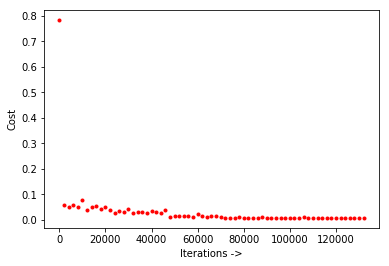

In [59]:
dim=[V,100,50,2]
cost_list,test_cost_list,iter_list,W,b=neural_network(0.1,dim,30,'tanh',train_X,train_Y,test_X,test_Y)
plot_cost(iter_list,cost_list)

In [60]:
y_pred=predict_as_one_hot(W,b,test_X,dim)
accuracy_score(test_Y,y_pred,normalize=True)

0.99012567324955114

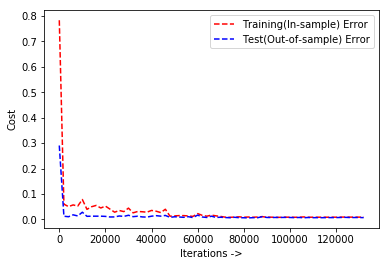

In [61]:
plot_together(iter_list,cost_list,test_cost_list)

In [ ]:
plot_cost(iter_list,test_cost_list)

In [ ]:
precision_recall_fscore_support(test_Y,y_pred,average='weighted')